In [1]:
import os
import json
import matplotlib
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import random
import shutil
from distutils.dir_util import copy_tree
import numpy as np

In [640]:
!pwd

/home/liang/internship/NeuroNER/NeuroNER-master/data/rpi/test/result


In [55]:
# load Stanford NER result and merge them
file_path = '/home/liang/internship/EDL-2018/result/RPI_2018_statistic_all_1235_data.csv'
df_stanfordner = pd.DataFrame.from_csv(file_path).sort_values('n_sentence')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


In [106]:
# checking how much entities are done by now
ls_sorted_all_entities = df_stanfordner['entity_type'].tolist()
running_entity ='Novice110363913'
now = ls_sorted_all_entities.index(running_entity) - 1
print('%5d/1235 entities are done'%(now))

# extract the finisth entities:
ls_entities = ls_sorted_all_entities[0:now]

  961/1235 entities are done


In [954]:
# for one fold
# extract detailed result from NeuroNER report 
def Extract_result1(ls_entity, data_path='NeuroNER/'):
# data_path = 'NeuroNER/'
    
    # extract from raw
    ls_n_epoch = []
    ls_train_duration = []
    ls_train_F1 = []
    ls_valid_F1 = []
    ls_vs_epoch = []

    for entity in ls_entity:
        output_path = data_path + entity +'/output/'
        folder_name = list(os.walk(output_path))[0][1][0]
        result_file_name = output_path + folder_name +'/results.json'
        with open(result_file_name ,'r') as f:
            result = json.load(f)
        ls_n_epoch.append(int(result['execution_details']['num_epochs']))
        ls_train_duration.append(int(result['execution_details']['train_duration']))
        ls_train_F1.append(result['train']['best_f1_conll']/100)
        ls_valid_F1.append(result['valid']['best_f1_conll']/100)
        temp =[]
        for i in range(int(result['execution_details']['num_epochs'])+1):
            temp.append(result['epoch'][str(i)][0]['valid']['f1_conll']['micro'])
        ls_vs_epoch.append(temp)
        
    # create dataframe
    df_NeuroNER = pd.DataFrame({'entity_type':ls_entity,'Neuro_n_epochs':ls_n_epoch,'Neuro_duration':ls_train_duration,
                                'Neuro_F1_on_train_set':ls_train_F1,'Neuro_F1_on_valid_set':ls_valid_F1})
    df_NeuroNER = df_NeuroNER[['entity_type', 'Neuro_n_epochs', 'Neuro_duration', 'Neuro_F1_on_train_set', 
                               'Neuro_F1_on_valid_set']]        
    
    return df_NeuroNER, ls_vs_epoch


In [15]:
# just extract vadid_F1
def Extract_vadid_F1(ls_entity, data_path='NeuroNER/'):
# data_path = 'NeuroNER/'
    
    # extract from raw
    ls_valid_F1 = []
    
    for entity in ls_entity:
        output_path = data_path + entity +'/output/'
        folder_name = list(os.walk(output_path))[0][1][0]
        result_file_name = output_path + folder_name +'/results.json'
        with open(result_file_name ,'r') as f:
            result = json.load(f)

        ls_valid_F1.append(result['valid']['best_f1_conll']/100)         
    return ls_valid_F1


In [16]:
ls /home/liang/internship/NeuroNER_1235_5foldCV/flod3Belemnite101973723/output/

ls: cannot access '/home/liang/internship/NeuroNER_1235_5foldCV/flod3Belemnite101973723/output/': No such file or directory


In [92]:
# extract 5_fold_result
data_path = '/home/liang/internship/NeuroNER_1235_5foldCV/'
folds = ['flod3/','fold0_small/', 'fold1_small/', 'fold2_small/', 'fold4_small/']
F1s = []
result = []
with open("../data/small_entities_set.txt", "rb") as fp:   # Unpickling
    ls_entities = pickle.load(fp)

    
for i in range(5):
    path = data_path + folds[i]
    F1s.append(Extract_vadid_F1(ls_entities, path))
    
result.append(ls_entities)   
result = result + F1s

#|create dataframe
df_NeuroNER = pd.DataFrame(result).T
df_NeuroNER = df_NeuroNER.rename(index=str, columns={0: "entity_type", 1: "N_fold3", 
                                                     2: "N_fold0", 3: "N_fold1", 4: "N_fold2", 5: "N_fold4"})
df_NeuroNER = df_NeuroNER[['entity_type', 'N_fold0', 'N_fold1', 'N_fold2', 
                           'N_fold3', 'N_fold4']]
df_NeuroNER['N_avg'] =  np.mean(df_NeuroNER[['N_fold0','N_fold1','N_fold2','N_fold3','N_fold4']], axis =1)
df_NeuroNER['N_std'] =  np.std(df_NeuroNER[['N_fold0','N_fold1','N_fold2','N_fold3','N_fold4']], axis =1)

In [93]:
df_NeuroNER.to_csv('df_neuro_711.csv')
df_NeuroNER.from_csv('df_neuro_711.csv')
df_NeuroNER.head(6)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


entity_type N_fold0 N_fold1 N_fold2 N_fold3 N_fold4    N_avg  \
0        Belemnite101973723  0.9825       1  0.8235  0.9302  0.9565  0.93854   
1  PlanetaryNebula109394797  0.8333  0.7895  0.8421  0.7391  0.8235  0.80550   
2        Threadfin102610980  0.8125  0.8571  0.9143    0.65  0.5946  0.76570   
3        Bumblebee102209624  0.6957  0.8525  0.7632  0.7368    0.75  0.75964   
4  DestroyerEscort103180732    0.92  0.7692  0.7273   0.875   0.625  0.78330   
5            Basin109215437    0.84  0.4211  0.6154  0.7586  0.5128  0.62958   

      N_std  
0  0.062187  
1  0.037686  
2  0.122709  
3  0.051650  
4  0.105347  
5  0.153769

In [94]:
df_stanfordner_711[['entity_type', 'n_sentence','F1_Stanford', 'F1_Stanford_std']].head(5)

entity_type  n_sentence  F1_Stanford  F1_Stanford_std
1019        Belemnite101973723          84      0.91580         0.080437
54    PlanetaryNebula109394797          88      0.81528         0.047105
1117        Threadfin102610980          93      0.61946         0.135302
257         Bumblebee102209624          98      0.71124         0.076284
370   DestroyerEscort103180732         100      0.80776         0.076364

In [95]:
# select the finished entities
df_stanfordner_711 = df_stanfordner.sort_values('n_sentence').iloc[:711]

df_stanfordner_711 = df_stanfordner_711.rename(index=str, columns={"F1_mean": "F1_Stanford", "F1_std": "F1_Stanford_std"})
df_merge1 = df_stanfordner_711[['entity_type', 'n_sentence','F1_Stanford', 'F1_Stanford_std']]
df_merge2 = df_NeuroNER[['entity_type', 'N_avg', 'N_std']]

df_all= pd.merge(df_merge1,df_merge2, on="entity_type")

# merge old data
# df_5 = pd.DataFrame.from_csv(file_path).sort_values('n_sentence')
# df_all = pd.concat([df_5[:5], df_all], axis=0, ignore_index=True)

In [96]:
df_all['S_N'] = df_all['F1_Stanford'] -df_all['N_avg']
df_all.to_csv('711.csv')
df_all.from_csv('711.csv')
df_all.head(10)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


entity_type  n_sentence  F1_Stanford  F1_Stanford_std  \
0         Belemnite101973723          84      0.91580         0.080437   
1   PlanetaryNebula109394797          88      0.81528         0.047105   
2         Threadfin102610980          93      0.61946         0.135302   
3         Bumblebee102209624          98      0.71124         0.076284   
4   DestroyerEscort103180732         100      0.80776         0.076364   
5             Basin109215437         106      0.63452         0.068988   
6            Cirque109245515         106      0.63452         0.068988   
7            Chiton103021121         120      0.66038         0.188334   
8             Tunic104497570         120      0.66038         0.188334   
9  EmploymentAgency108354352         120      0.23568         0.145874   

     N_avg     N_std      S_N  
0  0.93854  0.062187 -0.02274  
1  0.80550  0.037686  0.00978  
2  0.76570  0.122709 -0.14624  
3  0.75964  0.051650 -0.04840  
4  0.78330  0.105347  0.02446  
5  0.62958  0.153769  0.00494  
6  0.63618  0.135961 -0.00166  
7  0.77664  0.125211 -0.11626  
8  0.79270  0.085457 -0.13232  
9  0.53556  0.102511 -0.29988

In [97]:
df_all.describe()

n_sentence  F1_Stanford  F1_Stanford_std       N_avg       N_std  \
count  711.000000   711.000000       711.000000  711.000000  711.000000   
mean   478.623066     0.610777         0.106232    0.644313    0.087682   
std    208.283592     0.149579         0.061583    0.127780    0.050129   
min     84.000000     0.117520         0.005424    0.207100    0.008393   
25%    301.000000     0.520190         0.062831    0.560630    0.051062   
50%    470.000000     0.608520         0.091087    0.644900    0.078544   
75%    640.000000     0.709880         0.136914    0.732230    0.111432   
max    900.000000     0.994500         0.404296    0.991580    0.312661   

              S_N  
count  711.000000  
mean    -0.033536  
std      0.079171  
min     -0.341400  
25%     -0.075950  
50%     -0.021640  
75%      0.014370  
max      0.209140

KeyError: "['count'] not found in axis"

# check the convergence
* From this cell, you can randomly choose entities and plot their F1_score against epochs 
* since we have some kind of shorter tolerant(to shorten the training time) and the some entities have lower sentence size so the F1_vs_epochs for some entities is quite flactuate
* so the following cell just give you a quick way to have a idea how entities converge in this trail.
* how the stop metric work.
* in the legend :(entitiy name, number of sentence)

In [103]:
# check the convergence
# randomly choosing entities
n_entity = len(ls_vs_epoch)
ls_entities = []
ls_epoch = []
for i in range(10):
    index = random.randint(600,1000)
    ls_epoch.append(ls_vs_epoch[index])
    ls_entities.append(df_NeuroNER.iloc[index]['entity_type'])

# plot the accuracy against the degree# plot th 
plt.figure(figsize=(20,8))
for i,entity in enumerate(ls_entities):
    x = list(range(len(ls_epoch[i])))
    y = ls_epoch[i]
    n_sentence = int(df_all[df_all['entity_type'] == entity]['n_sentence'])
    label = entity + ', ' + str(n_sentence)
    plt.plot(x,y, label = label)
#     print(entity)
plt.title("F1_score vs epoch")
plt.xlabel("Epoch")
plt.ylabel("F1_score")
plt.grid(linestyle='-', linewidth=2)
plt.legend()
plt.show()


NameError: name 'ls_vs_epoch' is not defined

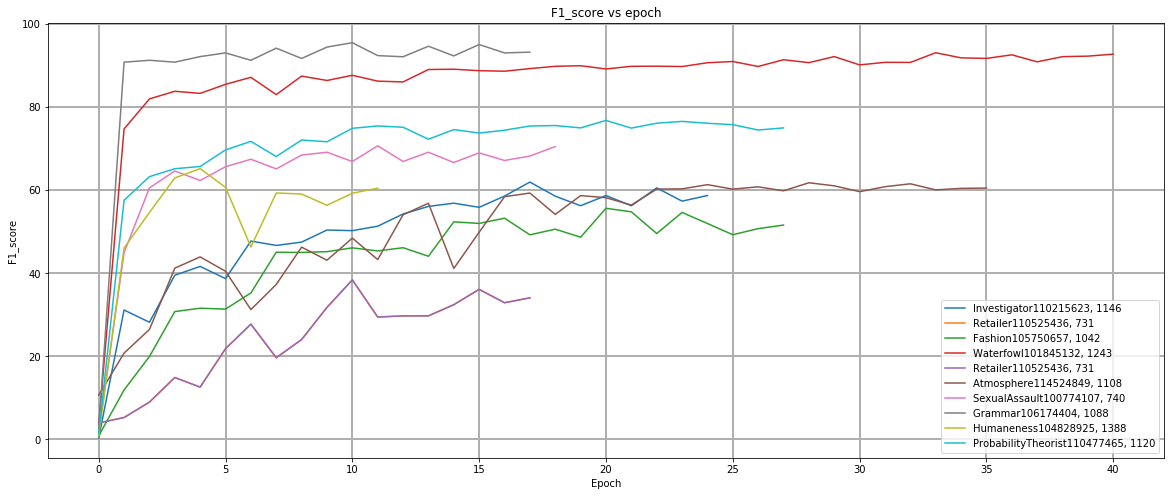

In [996]:
# check the convergence
# randomly choosing entities
n_entity = len(ls_vs_epoch)
ls_entities = []
ls_epoch = []
for i in range(10):
    index = random.randint(600,1000)
    ls_epoch.append(ls_vs_epoch[index])
    ls_entities.append(df_NeuroNER.iloc[index]['entity_type'])

# plot the accuracy against the degree# plot th 
plt.figure(figsize=(20,8))
for i,entity in enumerate(ls_entities):
    x = list(range(len(ls_epoch[i])))
    y = ls_epoch[i]
    n_sentence = int(df_all[df_all['entity_type'] == entity]['n_sentence'])
    label = entity + ', ' + str(n_sentence)
    plt.plot(x,y, label = label)
#     print(entity)
plt.title("F1_score vs epoch")
plt.xlabel("Epoch")
plt.ylabel("F1_score")
plt.grid(linestyle='-', linewidth=2)
plt.legend()
plt.show()


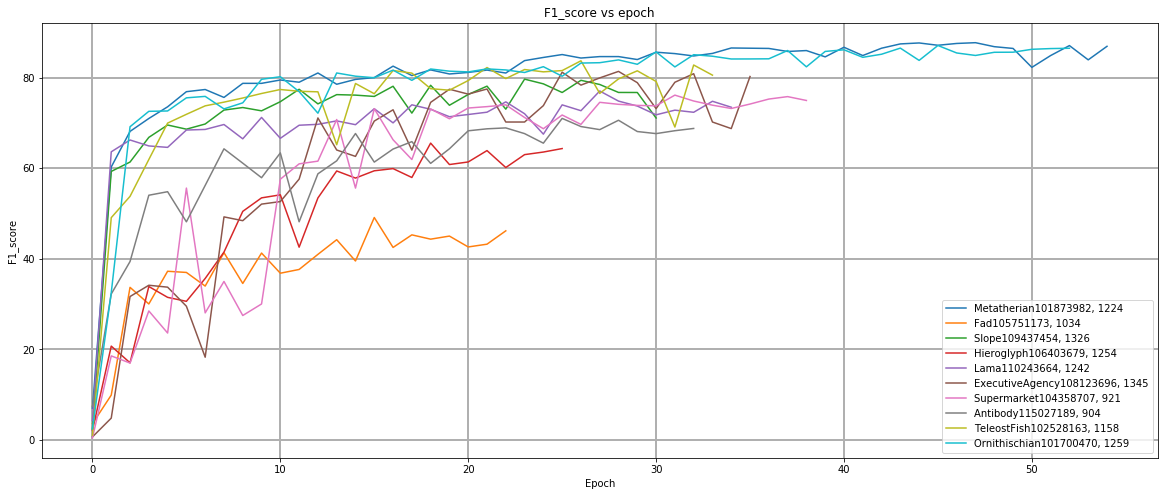

In [476]:
# check the convergence
# randomly choosing entities
n_entity = len(ls_vs_epoch)
ls_entities = []
ls_epoch = []
for i in range(10):
    index = random.randint(700,n_entity-1)
    ls_epoch.append(ls_vs_epoch[index])
    ls_entities.append(df_NeuroNER.iloc[index]['entity_type'])

# plot the accuracy against the degree# plot th 
plt.figure(figsize=(20,8))
for i,entity in enumerate(ls_entities):
    x = list(range(len(ls_epoch[i])))
    y = ls_epoch[i]
    n_sentence = int(df_all[df_all['entity_type'] == entity]['n_sentence'])
    label = entity + ', ' + str(n_sentence)
    plt.plot(x,y, label = label)
#     print(entity)
plt.title("F1_score vs epoch")
plt.xlabel("Epoch")
plt.ylabel("F1_score")
plt.grid(linestyle='-', linewidth=2)
plt.legend()
plt.show()

## Compare the F1 between StanfordNER and NeuroNER

* the entities is sorted by the number of sentence, like entities in the left have less sentence size.
* reuslt of StanfordNER(Red) and NeuroNER(Blue) overlap in the same x position, 
    * so the if edge is red, means StanfordNER better than NeuroNER, otherwise it is blue
    * still keep that StanfordNER is average from 5-fold CV but NeuroNER just one
    
* some of entities are almost convergence while still increasing silghtly and slowly, like CarnivorousBat(gray), it was stop by the NeuroNER default stop metric. (so in the below graph to compare the F1 with Stanford NER, some NeuroNER result could be a slihtly higher)

* some entities seem still no convergence, flactuating a lot, but since no improvement in validation for a while (7 epochs) them are stop by the NeuroNER default stop metric.(Protozoan, red, with few sentence size)

* that is what i means the default stop metric by NeuroNER maybe not fit very well for RPI data, since some entities don't have very enough data for a NeuroNER, and the data are little noisy.

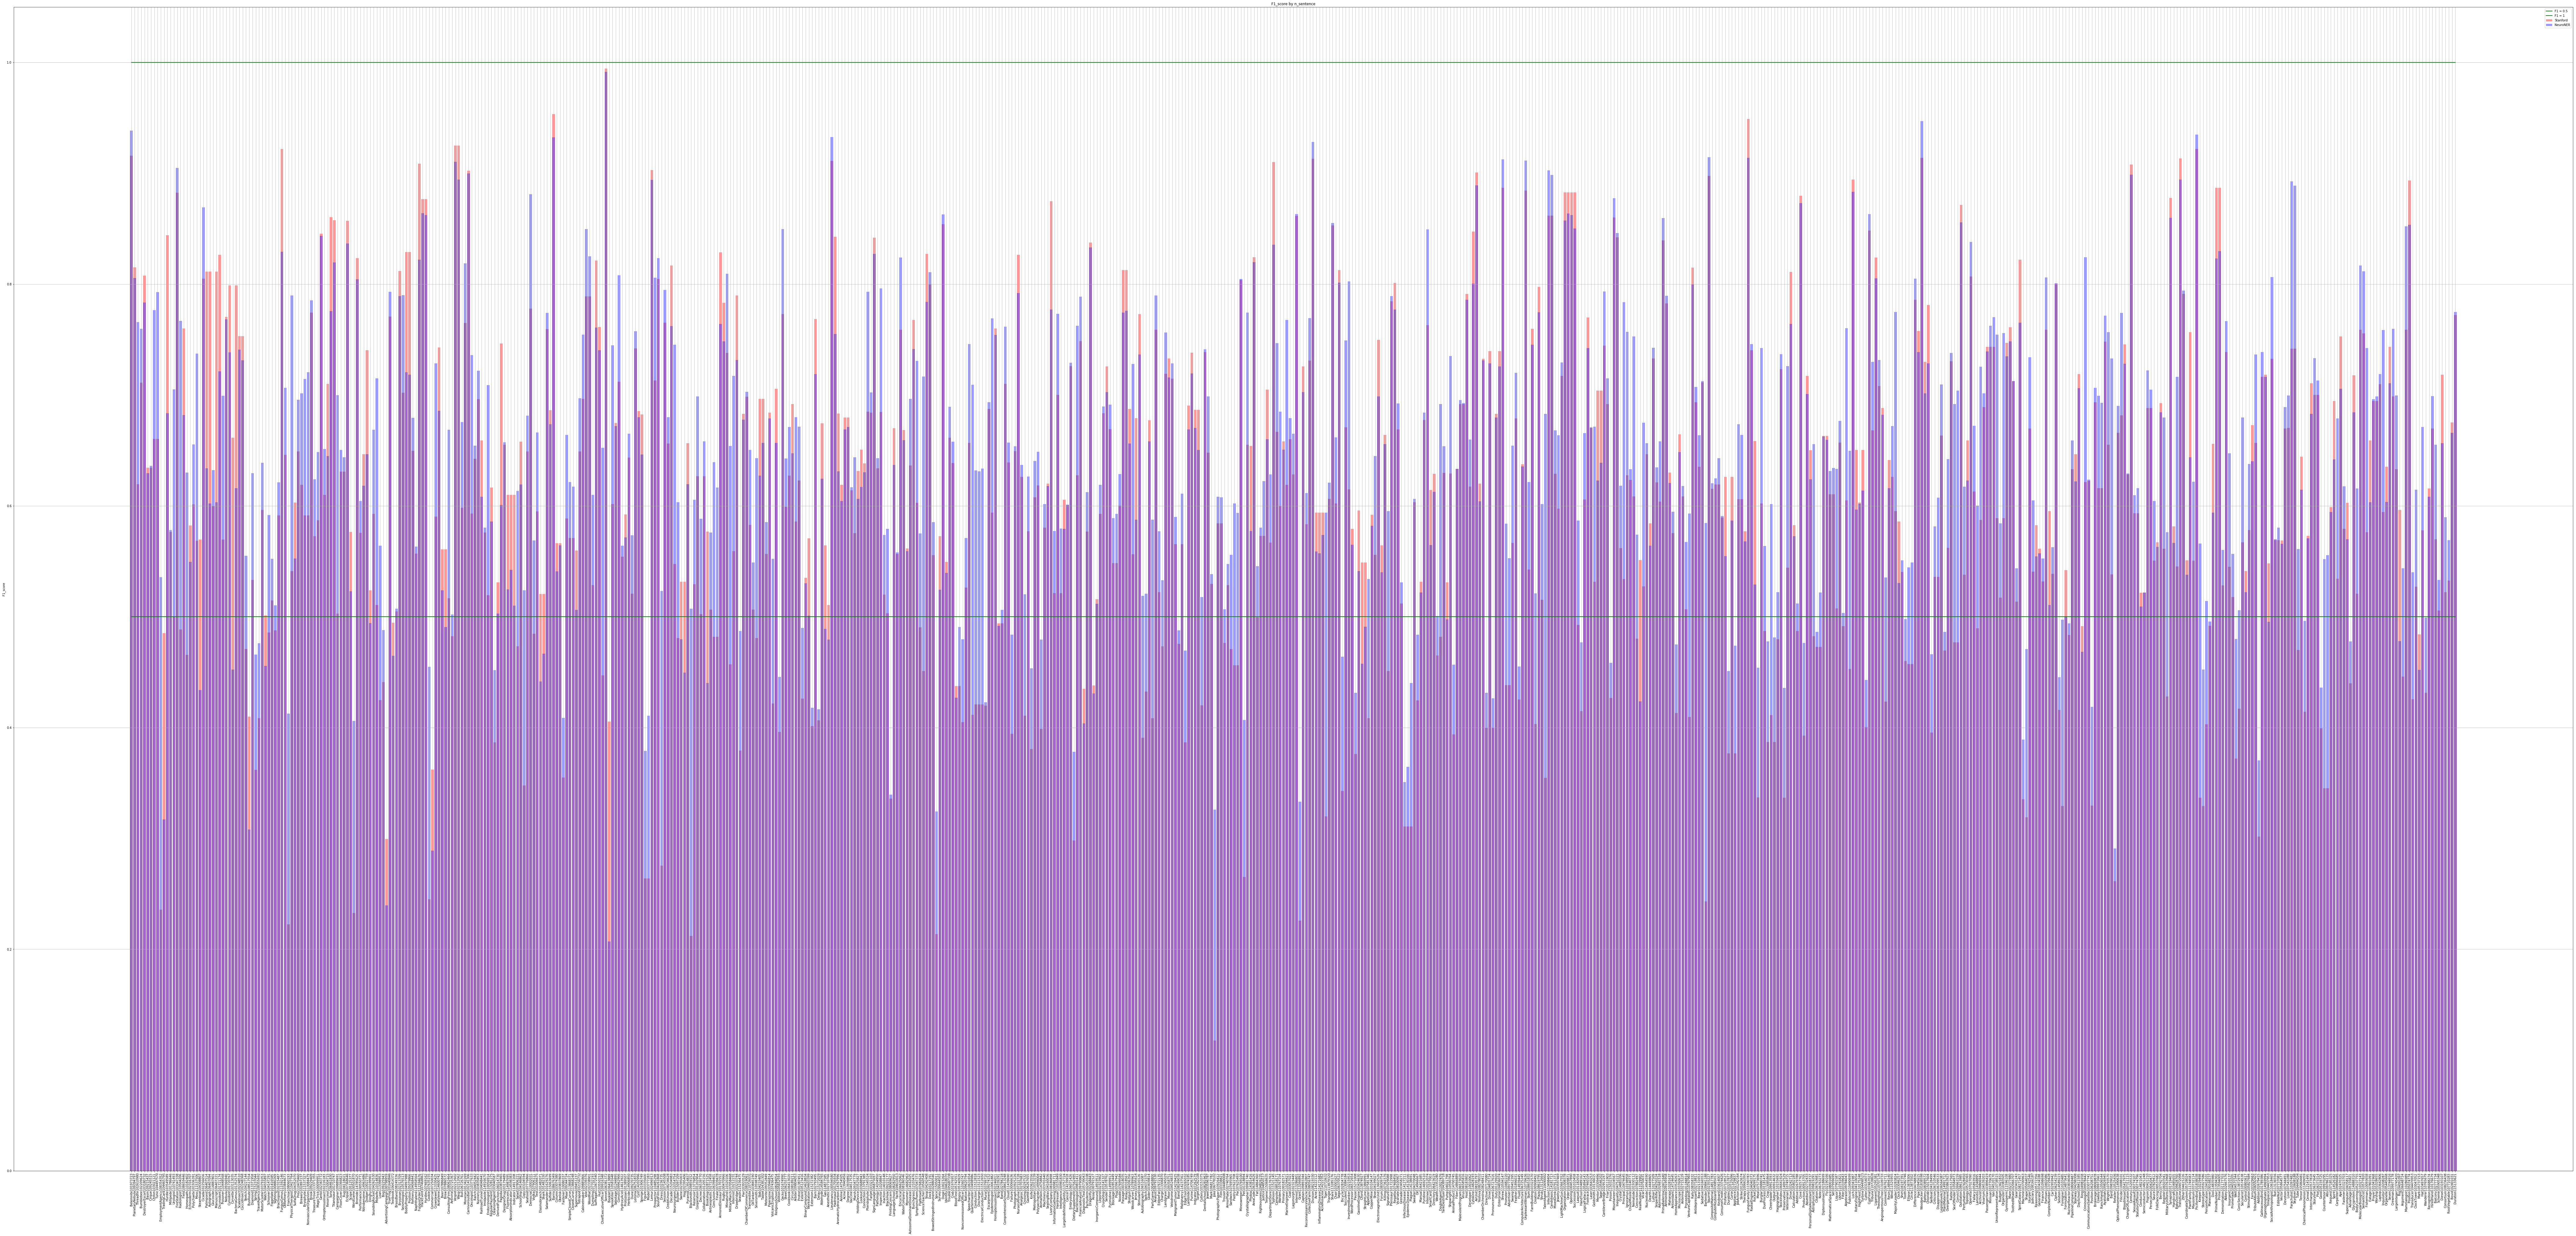

In [152]:
# data
bars1 = df_all['F1_Stanford']
bars2 = df_all['N_avg']
y_pos = np.arange(len(bars1))


fig, ax = plt.subplots(figsize=(150,40)) 
plt.bar(y_pos, bars1, align='center', color = 'r', alpha=0.4, label = 'Stanford')
plt.bar(y_pos,bars2, color = 'b', alpha=0.4,  label = 'NeuroNER')
plt.plot(y_pos,np.ones(len(bars2))/2, color = 'green', label = 'F1 = 0.5', linewidth=2.0)
plt.plot(y_pos,np.ones(len(bars2)), color = 'green', label = 'F1 = 1', linewidth=2.0)

plt.xticks(y_pos, df_all['entity_type'],rotation='vertical')
plt.ylabel('F1_score')
plt.title('F1_score by n_sentence')

plt.grid()
plt.legend()
plt.savefig('711_overlap2.pdf')
plt.show()

#### StanfordNER - NeuroNER
 * postive bar means StanfordNER better than NeuroNER, otherwise it is blue

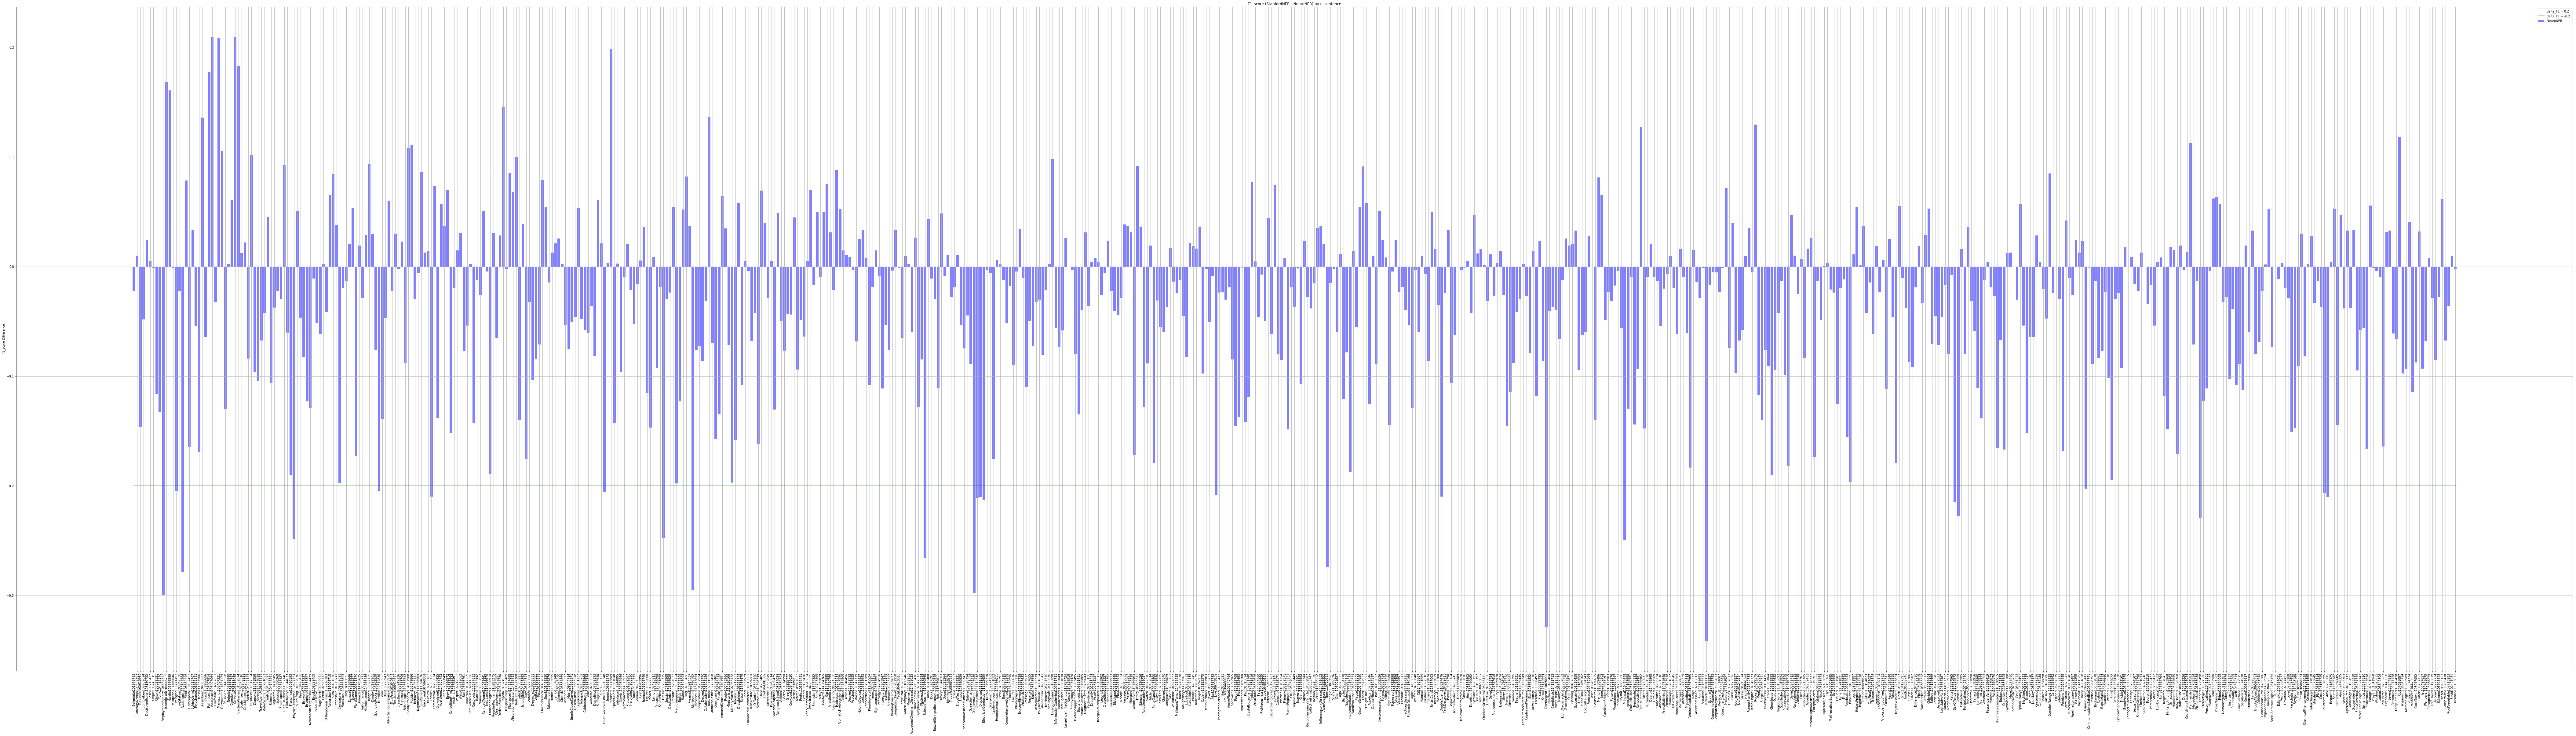

In [150]:
# data
bars1 = df_all['F1_Stanford']
bars2 = df_all['N_avg']
bars3 = bars1 - bars2
y_pos = np.arange(len(bars1))


fig, ax = plt.subplots(figsize=(150,40))


plt.bar(y_pos,bars3, color = 'b', alpha=0.5,  label = 'NeuroNER')

plt.plot(y_pos,np.ones(len(bars2))/5, color = 'green', label = 'delta_F1 = 0.2', linewidth=2.0)
plt.plot(y_pos,np.ones(len(bars2))/5*(-1), color = 'green', label = 'delta_F1 = -0.2', linewidth=2.0)

plt.xticks(y_pos, df_all['entity_type'],rotation='vertical')
plt.ylabel('F1_score Difference')
plt.title('F1_score (StanfordNER - NeuroNER) by n_sentence')

plt.grid()
plt.legend()
plt.savefig('711_substract.pdf')


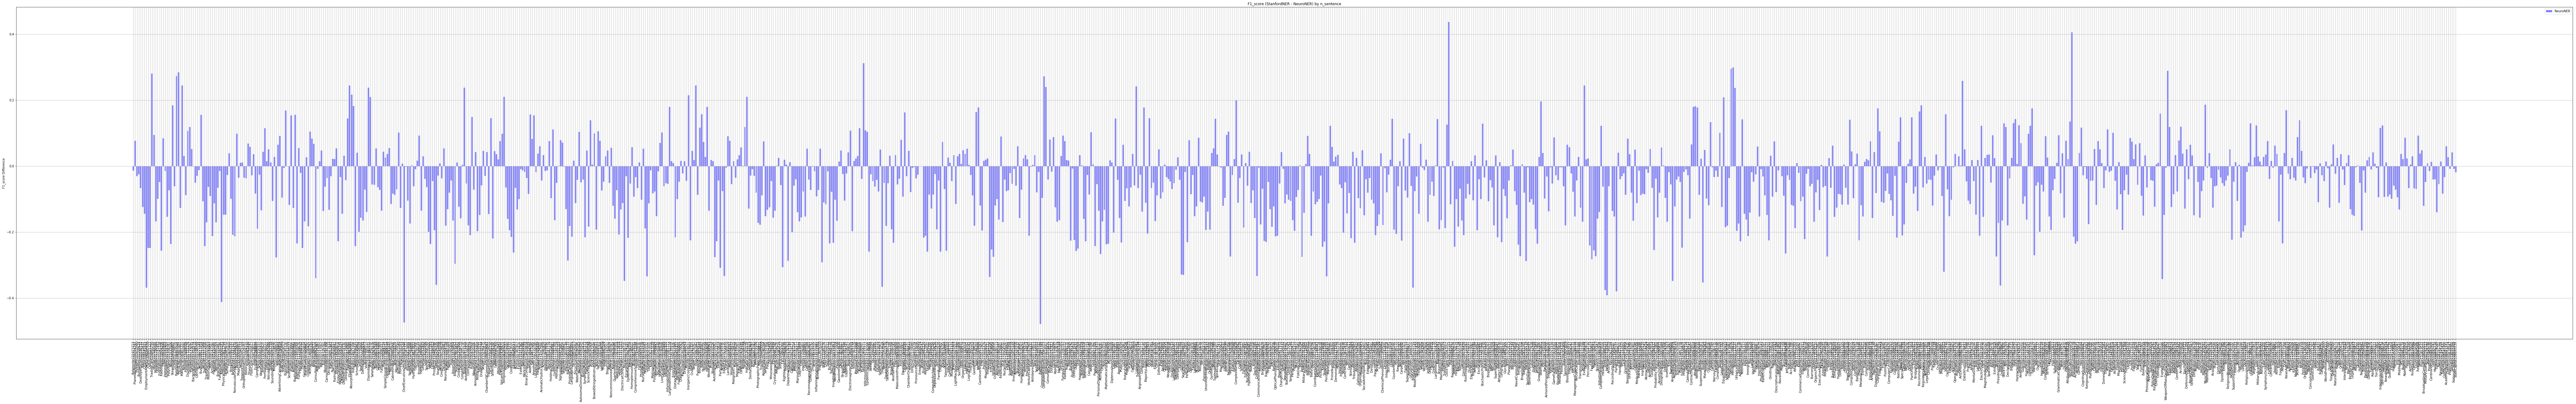

In [728]:
# data
bars1 = df_all['F1_Stanford']
bars2 = df_all['Neuro_F1_on_valid_set']
bars3 = bars1 - bars2
y_pos = np.arange(len(bars1))


fig, ax = plt.subplots(figsize=(150,20))


plt.bar(y_pos,bars3, color = 'b', alpha=0.5,  label = 'NeuroNER')


plt.xticks(y_pos, df_all['entity_type'],rotation='vertical')
plt.ylabel('F1_score Difference')
plt.title('F1_score (StanfordNER - NeuroNER) by n_sentence')

plt.grid()
plt.legend()
plt.savefig('711_substract.pdf')



In [744]:
# the number of entities that StanfordNER F1 better than NeuroNER F1
len([x for x in bars3 if x >0])

424

In [749]:
# the number of entities that NeuroNER F1 better than StanfordNER F1
len([x for x in bars3 if x <0])

811

In [746]:
# the number of entities that NeuroNER F1 better than StanfordNER F1
np.mean([x for x in bars3 if x >0])

0.07171391509433962

In [747]:
np.mean([x for x in bars3 if x <0])

-0.11187117139334155

we can find that:
    * Stanford are better for some entities, and for others NeuroNER is better, but NeuroNER have more better result then Stanford.
    * for thoes entities with more sentence, NeuroNER is more like to performance better.(right part of the figure)

### Plot the training duration vs entities
* he entities is sorted by the number of sentence, like entities in the left have less sentence size.

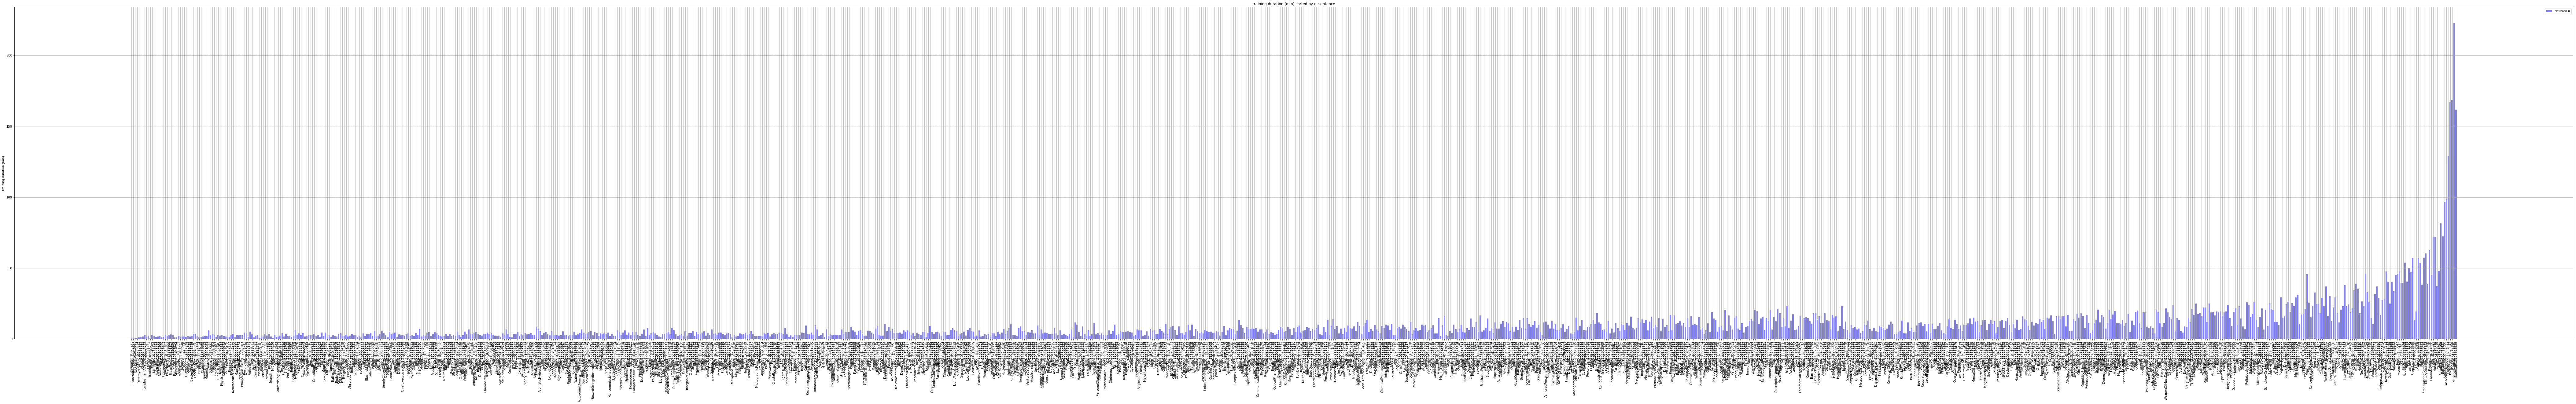

In [730]:
# data
bars1 = df_all['Neuro_duration']/60
y_pos = np.arange(len(bars1))

fig, ax = plt.subplots(figsize=(150,20))
plt.bar(y_pos,bars1, color = 'b', alpha=0.5,  label = 'NeuroNER')


plt.xticks(y_pos, df_all['entity_type'],rotation='vertical')
plt.ylabel('training duration (min)')
plt.title('training duration (min) sorted by n_sentence')

plt.grid()
plt.legend()
plt.savefig('duration.pdf')

from above two plots we can find that :
    * during to our stop metric, number of epoch of the entity seems have no clear relationship with number of sentence.(first figure)
    * but for entities with more sentence, we tend to have more training duration, longer time in each epoch.(second figure)

## Select entities for analysis

select metric:
* entities that have large performance gap between StanfordNER and NeuroNER
    * small sentence size, and StanfordNER much better than NeuroNER
    * small sentence size, and NeuroNER much better than StanfordNER
    * large sentence size, and StanfordNER much better than NeuroNER
    * large sentence size, and NeuroNER much better than StanfordNER
    * other entities with largest performance gap
    
* top 15 entities that with large sentence size(>1400) but performance bad in both StanfordNER and NeuroNER(<0.5)

* top 15 entities that with small sentence size(<700) but performance good in both StanfordNER and NeuroNER(>0.85)

In [759]:
df_all.describe()

n_document    n_sentence  F1_Stanford  Neuro_n_epochs  Neuro_duration  \
count  1235.000000   1235.000000  1235.000000     1235.000000     1235.000000   
mean     14.284211   1378.661538     0.641540       22.659109      580.072874   
std      23.154356   2316.398490     0.153952       10.306230      859.130799   
min       1.000000     84.000000     0.117000        4.000000       22.000000   
25%       5.000000    425.500000     0.545740       15.000000      205.000000   
50%       8.000000    744.000000     0.648980       21.000000      359.000000   
75%      15.000000   1449.000000     0.753600       28.000000      668.500000   
max     374.000000  37373.000000     0.994500       61.000000    13374.000000   

       Neuro_F1_on_train_set  Neuro_F1_on_valid_set          S_N  
count            1235.000000            1235.000000  1235.000000  
mean                0.867729               0.690383    -0.048843  
std                 0.071796               0.152072     0.118618  
min                 0.471500               0.047500    -0.478880  
25%                 0.826600               0.595650    -0.122530  
50%                 0.875500               0.706900    -0.041840  
75%                 0.921500               0.799550     0.024590  
max                 0.996600               0.996300     0.436420

In [911]:
# analysis the general performance category be sentence size
# find the 1/3 points
print(df_all.iloc[411]['n_sentence'],df_all.iloc[822]['n_sentence'])

525 1160


In [907]:
part = ['1st_1/3','2nd_1/3','3rd_1/3']
n_entities = [412,412,411]
n_S_N = [152,114,158]
n_N_S = [a_i - b_i for a_i, b_i in zip(n_entities, n_S_N)]
average_S_N =[0.07905460526315788, 0.06357526315789473, 0.07052417721518987]
average_N_S = [-0.11829353846153846, -0.12287912751677851, -0.09230521739130434]
df1 = pd.DataFrame({'part':part,'n_entities':n_entities,'n_Stanford>Neuro':n_S_N,
                    'n_Neuro>Stanford':n_N_S,'avg_Stanford>Neuro':average_S_N,'avg_Neuro>Stanford':average_N_S})
df1 = df1[['part', 'n_entities', 'n_Stanford>Neuro', 'n_Neuro>Stanford', 
           'avg_Stanford>Neuro', 'avg_Neuro>Stanford']]        
df1    

part  n_entities  n_Stanford>Neuro  n_Neuro>Stanford  \
0  1st_1/3         412               152               260   
1  2nd_1/3         412               114               298   
2  3rd_1/3         411               158               253   

   avg_Stanford>Neuro  avg_Neuro>Stanford  
0            0.079055           -0.118294  
1            0.063575           -0.122879  
2            0.070524           -0.092305

In [ ]:
# choose the entities
* document > 5

In [935]:
df_threshold = df_all.iloc[275:]
df_N_S_20 = df_threshold.sort_values('S_N').iloc[:20][['entity_type', 'n_sentence', 
                                                      'F1_Stanford', 'Neuro_F1_on_valid_set', 'S_N']]
df_S_N_20 = df_threshold.sort_values('S_N').iloc[-20:][['entity_type', 'n_sentence', 
                                                      'F1_Stanford', 'Neuro_F1_on_valid_set', 'S_N']]
df_SN = df_threshold.sort_values('S_N').iloc[628:643]

In [832]:
df_threshold.describe()

n_document    n_sentence  F1_Stanford  Neuro_n_epochs  Neuro_duration  \
count  960.000000    960.000000   960.000000      960.000000      960.000000   
mean    17.492708   1698.033333     0.649151       22.957292      694.079167   
std     25.365153   2538.499742     0.153067       10.683876      943.064597   
min      5.000000    401.000000     0.117000        4.000000       88.000000   
25%      7.000000    626.500000     0.555230       15.000000      280.750000   
50%     10.000000    993.000000     0.660320       21.000000      462.000000   
75%     18.000000   1753.250000     0.758450       29.000000      789.250000   
max    374.000000  37373.000000     0.949120       61.000000    13374.000000   

       Neuro_F1_on_train_set  Neuro_F1_on_valid_set         S_N  
count             960.000000             960.000000  960.000000  
mean                0.879350               0.698779   -0.049628  
std                 0.063154               0.150400    0.115461  
min                 0.637500               0.047500   -0.478880  
25%                 0.841675               0.605250   -0.118330  
50%                 0.886750               0.711900   -0.042610  
75%                 0.927300               0.811475    0.020600  
max                 0.994900               0.995100    0.436420

In [915]:
ls_rerun = set()

In [936]:
###
df_threshold.sort_values('S_N').iloc[:20][['entity_type', 'n_sentence', 
                                                      'F1_Stanford','F1_Stanford_std', 'Neuro_F1_on_valid_set', 'S_N']]

entity_type  n_sentence  F1_Stanford  F1_Stanford_std  \
482         Bartender109841188         596      0.24312         0.058510   
783           Helping107578363        1051      0.49000         0.219030   
788          Parlance107081177        1078      0.18706         0.094149   
782             Drink107885223        1051      0.49000         0.219030   
680      BodyCovering105237755         843      0.52066         0.274799   
398         Directory106423619         517      0.62892         0.270768   
992          Lobbyist110268629        1737      0.49096         0.128807   
834            Booker109865954        1173      0.39564         0.171209   
818    AnimalMaterial114755804        1151      0.47592         0.245291   
1078        Euphemism106605046        2398      0.41250         0.241741   
455           Crystal114883206         559      0.56196         0.283141   
634   Personification110418101         767      0.40302         0.229936   
597     Criminologist109978442         714      0.62142         0.174907   
314         EdibleFat107672135         428      0.52224         0.222882   
558       SexOffender110584973         663      0.47678         0.198395   
557           Convict109963159         663      0.47678         0.198395   
962            Novice110363913        1601      0.51144         0.316124   
312         PartyGame100458800         427      0.40844         0.116852   
345               Fat114864360         459      0.49948         0.214989   
366             Tiger110710632         481      0.31978         0.057915   

      Neuro_F1_on_valid_set      S_N  
482                  0.7220 -0.47888  
783                  0.8822 -0.39220  
788                  0.5672 -0.38014  
782                  0.8663 -0.37630  
680                  0.8896 -0.36894  
398                  0.9951 -0.36618  
992                  0.8531 -0.36214  
834                  0.7489 -0.35326  
818                  0.8247 -0.34878  
1078                 0.7554 -0.34290  
455                  0.8987 -0.33674  
634                  0.7372 -0.33418  
597                  0.9550 -0.33358  
314                  0.8556 -0.33336  
558                  0.8071 -0.33032  
557                  0.8060 -0.32922  
962                  0.8326 -0.32116  
312                  0.7176 -0.30916  
345                  0.8061 -0.30662  
366                  0.6120 -0.29222

In [916]:
###
df_temp = df_threshold.sort_values('S_N').iloc[:20][['entity_type', 'n_sentence', 
                                                      'F1_Stanford', 'Neuro_F1_on_valid_set', 'S_N']]
ls_rerun.update(df_temp[df_temp['n_sentence']>900]['entity_type'])

In [899]:
###
df_threshold[df_threshold['n_sentence']<525].sort_values('S_N').iloc[:15][['entity_type', 'n_sentence', 
                                                      'F1_Stanford', 'Neuro_F1_on_valid_set', 'S_N']]

entity_type  n_sentence  F1_Stanford  \
398          Directory106423619         517      0.62892   
314          EdibleFat107672135         428      0.52224   
312          PartyGame100458800         427      0.40844   
345                Fat114864360         459      0.49948   
366              Tiger110710632         481      0.31978   
348    DepartmentStore103176763         462      0.56674   
309      Autobiography106516087         426      0.39084   
391             Plague114138691         510      0.31080   
370            Bicycle102834778         488      0.34286   
404      AnimalProduct114700745         521      0.39380   
372   InvestmentBanker110215953         490      0.61488   
310             Switch104372370         427      0.43236   
296            Leporid102323902         414      0.59278   
288  DietarySupplement107562495         411      0.29818   
350           Campsite108518171         464      0.66684   

     Neuro_F1_on_valid_set      S_N  
398                 0.9951 -0.36618  
314                 0.8556 -0.33336  
312                 0.7176 -0.30916  
345                 0.8061 -0.30662  
366                 0.6120 -0.29222  
348                 0.8542 -0.28746  
309                 0.6667 -0.27586  
391                 0.5702 -0.25940  
370                 0.5771 -0.23424  
404                 0.6267 -0.23290  
372                 0.8476 -0.23272  
310                 0.6604 -0.22804  
296                 0.8182 -0.22542  
288                 0.5146 -0.21642  
350                 0.8673 -0.20046

In [900]:
###
df_threshold[df_threshold['n_sentence']>1160].sort_values('S_N').iloc[:15][['entity_type', 'n_sentence', 
                                                      'F1_Stanford', 'Neuro_F1_on_valid_set', 'S_N']]

entity_type  n_sentence  F1_Stanford  Neuro_F1_on_valid_set  \
992       Lobbyist110268629        1737      0.49096                 0.8531   
834         Booker109865954        1173      0.39564                 0.7489   
1078     Euphemism106605046        2398      0.41250                 0.7554   
962         Novice110363913        1601      0.51144                 0.8326   
990           Myth106372680        1730      0.54494                 0.8198   
900       Dictator110012244        1361      0.63028                 0.9049   
1010       Rancher110506417        1867      0.68186                 0.9530   
878          Fairy109540430        1289      0.32088                 0.5857   
1032  Accordionist109761310        1988      0.48420                 0.7200   
1142       Address108491027        3322      0.51988                 0.7546   
854     Agronomist109780120        1233      0.56386                 0.7924   
1033     Aesthetic105968971        1990      0.31570                 0.5437   
869          Piece103932203        1258      0.75278                 0.9784   
917     Philosophy106158346        1434      0.54138                 0.7664   
1115    Woodworker110790192        2815      0.65582                 0.8797   

          S_N  
992  -0.36214  
834  -0.35326  
1078 -0.34290  
962  -0.32116  
990  -0.27486  
900  -0.27462  
1010 -0.27114  
878  -0.26482  
1032 -0.23580  
1142 -0.23472  
854  -0.22854  
1033 -0.22800  
869  -0.22562  
917  -0.22502  
1115 -0.22388

In [901]:
###
df_threshold.sort_values('S_N').iloc[-20:][['entity_type', 'n_sentence', 
                                                      'F1_Stanford', 'Neuro_F1_on_valid_set', 'S_N']]

entity_type  n_sentence  F1_Stanford  \
950              Advice106671484        1541      0.76634   
1101    MusicalNotation106814870        2673      0.70566   
748         SitarPlayer110603851         979      0.76266   
586       ComplexNumber113729428         690      0.59522   
845     EquestrianSport100450700        1207      0.67266   
326           Indicator107262579         436      0.68672   
295   InorganicCompound114919511         414      0.51590   
851               Smell105713737        1225      0.82294   
485            Keyboard103614007         601      0.61932   
533            Ligament105295381         641      0.82394   
299                Plug103967942         421      0.54832   
771          Evaluation105736149        1029      0.53358   
972                Cell102991711        1657      0.60184   
484    ComputerKeyboard103085013         601      0.61932   
1081         WaterSport100441824        2457      0.68916   
849           Sensation105712076        1225      0.82294   
850          Perception105708432        1225      0.82294   
388             Grenade103458271         509      0.51198   
1030         WadingBird102000954        1976      0.81600   
699                Mark105737153         871      0.48392   

      Neuro_F1_on_valid_set      S_N  
950                  0.5828  0.18354  
1101                 0.5199  0.18576  
748                  0.5667  0.19596  
586                  0.3962  0.19902  
845                  0.4645  0.20816  
326                  0.4768  0.20992  
295                  0.3014  0.21450  
851                  0.5864  0.23654  
485                  0.3802  0.23912  
533                  0.5830  0.24094  
299                  0.3040  0.24432  
771                  0.2892  0.24438  
972                  0.3440  0.25784  
484                  0.3475  0.27182  
1081                 0.4005  0.28866  
849                  0.5274  0.29554  
850                  0.5240  0.29894  
388                  0.2000  0.31198  
1030                 0.4106  0.40540  
699                  0.0475  0.43642

In [902]:
####
df_threshold[df_threshold['n_sentence']>1160].sort_values('S_N').iloc[-15:][['entity_type', 'n_sentence', 
                                                      'F1_Stanford', 'Neuro_F1_on_valid_set', 'S_N']]

entity_type  n_sentence  F1_Stanford  \
1144       NewsAgency108355075        3389      0.86016   
1009        Explosive103304730        1864      0.61432   
927   CognitiveFactor105686481        1464      0.55096   
831       WorldRecord100063559        1170      0.83930   
829            Record100063014        1170      0.83930   
830        Attainment100062806        1170      0.83930   
950            Advice106671484        1541      0.76634   
1101  MusicalNotation106814870        2673      0.70566   
845   EquestrianSport100450700        1207      0.67266   
851             Smell105713737        1225      0.82294   
972              Cell102991711        1657      0.60184   
1081       WaterSport100441824        2457      0.68916   
849         Sensation105712076        1225      0.82294   
850        Perception105708432        1225      0.82294   
1030       WadingBird102000954        1976      0.81600   

      Neuro_F1_on_valid_set      S_N  
1144                 0.6906  0.16956  
1009                 0.4395  0.17482  
927                  0.3760  0.17496  
831                  0.6617  0.17760  
829                  0.6599  0.17940  
830                  0.6583  0.18100  
950                  0.5828  0.18354  
1101                 0.5199  0.18576  
845                  0.4645  0.20816  
851                  0.5864  0.23654  
972                  0.3440  0.25784  
1081                 0.4005  0.28866  
849                  0.5274  0.29554  
850                  0.5240  0.29894  
1030                 0.4106  0.40540

In [903]:
####
df_threshold[df_threshold['n_sentence']<525].sort_values('S_N').iloc[-15:][['entity_type', 'n_sentence', 
                                                      'F1_Stanford', 'Neuro_F1_on_valid_set', 'S_N']]

entity_type  n_sentence  F1_Stanford  \
281            LiveryCompany108186898         404      0.87486   
390          EpidemicDisease114130166         510      0.31080   
381      ElectromagneticUnit113602526         500      0.74970   
389        InfectiousDisease114127211         510      0.31080   
386                  Regatta107468456         506      0.80102   
301                 Blockage102853449         421      0.54832   
325                   Target107262108         436      0.68672   
302                    Relay100318567         422      0.81258   
410                 Cytokine114828193         524      0.84736   
285  LargeIndefiniteQuantity113757724         409      0.60532   
305                  Passage100318035         422      0.81258   
326                Indicator107262579         436      0.68672   
295        InorganicCompound114919511         414      0.51590   
299                     Plug103967942         421      0.54832   
388                  Grenade103458271         509      0.51198   

     Neuro_F1_on_valid_set      S_N  
281                 0.7735  0.10136  
390                 0.2073  0.10350  
381                 0.6426  0.10710  
389                 0.2024  0.10840  
386                 0.6862  0.11482  
301                 0.4324  0.11592  
325                 0.5682  0.11852  
302                 0.6552  0.15738  
410                 0.6845  0.16286  
285                 0.4262  0.17912  
305                 0.6328  0.17978  
326                 0.4768  0.20992  
295                 0.3014  0.21450  
299                 0.3040  0.24432  
388                 0.2000  0.31198

In [894]:
# those entities with small sentences size (< 900) but high F1 (> 0.85) 
print('number of entities: ',df_threshold[(df_threshold['F1_Stanford'] > 0.85) & (df_threshold['Neuro_F1_on_valid_set'] > 0.85) 
    & (df_threshold['n_sentence'] < 700)]['entity_type'].count())
df_both_high =  df_threshold[(df_threshold['F1_Stanford'] > 0.85) & (df_threshold['Neuro_F1_on_valid_set'] > 0.85) 
    & (df_threshold['n_sentence'] < 700)]

number of entities:  15


In [926]:
# those entities with large sentences size (> 1500) but high F1 (< 0.5) 
print('number of entities: ',df_threshold[(df_threshold['F1_Stanford'] < 0.5) & (df_threshold['Neuro_F1_on_valid_set'] < 0.5) 
    & (df_threshold['n_sentence'] > 1400)]['entity_type'].count())
df_both_high =  df_threshold[(df_threshold['F1_Stanford'] < 0.5 ) & (df_threshold['Neuro_F1_on_valid_set'] < 0.5) 
    & (df_threshold['n_sentence'] > 1400)]

number of entities:  16


In [939]:
with open("rerun.txt", "wb+") as fp:   #Pickling
    pickle.dump(list(ls_rerun), fp)


In [941]:
pwd

'/home/liang/internship/NeuroNER/NeuroNER-master/data/rpi/test/result'

In [927]:
###
df_temp = df_both_high
ls_rerun.update(df_temp[df_temp['n_sentence']>900]['entity_type'])

In [891]:
df_both_high

entity_type  n_document  n_sentence  F1_Stanford  \
913          ComputerSystem103085915          15        1415      0.46620   
914                 Veteran110749528          15        1423      0.32722   
923             FilmCompany108003173          15        1443      0.49230   
929                Trickery100752954          15        1476      0.38370   
930                   Fraud100753685          15        1476      0.38370   
953         LegalProfession108112402          16        1556      0.43406   
975                Practice105667196          17        1678      0.11700   
985                Glossary106420781          18        1706      0.38600   
993             Distributor110018861          18        1748      0.24064   
1047         DomesticAnimal101317541          21        2095      0.34716   
1070  PhilosophicalDoctrine106167328          24        2348      0.35084   
1092            Liabilities113396054          26        2565      0.41490   
1097                   Meme105985126          27        2622      0.38168   
1104                 Mascot110297234          28        2711      0.32580   
1152                  Motto107152259          37        3603      0.39588   
1184              Neologism106294441          47        4619      0.28868   

      Neuro_n_epochs  Neuro_duration  Neuro_F1_on_train_set  \
913               21             587                 0.7961   
914               15             457                 0.8545   
923               14             421                 0.8738   
929               16             509                 0.8318   
930               15             479                 0.8173   
953               10             320                 0.7854   
975               18             655                 0.8526   
985               12             391                 0.7742   
993               23             816                 0.8867   
1047              22             951                 0.8057   
1070              10             525                 0.7596   
1092              15             898                 0.7859   
1097              18            1067                 0.8514   
1104              19            1129                 0.9354   
1152              13            1042                 0.8656   
1184              15            1585                 0.8636   

      Neuro_F1_on_valid_set      S_N  
913                  0.4221  0.04410  
914                  0.4244 -0.09718  
923                  0.4172  0.07510  
929                  0.4928 -0.10910  
930                  0.4949 -0.11120  
953                  0.4875 -0.05344  
975                  0.2218 -0.10480  
985                  0.3525  0.03350  
993                  0.4059 -0.16526  
1047                 0.4141 -0.06694  
1070                 0.4162 -0.06536  
1092                 0.4554 -0.04050  
1097                 0.4300 -0.04832  
1104                 0.3627 -0.03690  
1152                 0.3495  0.04638  
1184                 0.4842 -0.19552

In [889]:
# those entities with large sentences stanford poor but neuroner good

print('number of entities: ',df_threshold[(df_threshold['F1_Stanford'] < 0.5) & (df_threshold['Neuro_F1_on_valid_set'] > 0.5) 
    & (df_threshold['n_sentence'] > 1500)]['entity_type'].count())
df_both_high =  df_threshold[(df_threshold['F1_Stanford'] < 0.5 ) & (df_threshold['Neuro_F1_on_valid_set'] < 0.5) 
    & (df_threshold['n_sentence'] > 1500)]

number of entities:  8


In [887]:
df_N_S_20 = df_threshold[df_threshold['n_sentence'] > 1500].sort_values('S_N').iloc[:10][['entity_type', 'n_sentence', 
                                                      'F1_Stanford', 'Neuro_F1_on_valid_set', 'S_N']]
df_N_S_20

entity_type  n_sentence  F1_Stanford  Neuro_F1_on_valid_set  \
992       Lobbyist110268629        1737      0.49096                 0.8531   
1078     Euphemism106605046        2398      0.41250                 0.7554   
962         Novice110363913        1601      0.51144                 0.8326   
990           Myth106372680        1730      0.54494                 0.8198   
1010       Rancher110506417        1867      0.68186                 0.9530   
1032  Accordionist109761310        1988      0.48420                 0.7200   
1142       Address108491027        3322      0.51988                 0.7546   
1033     Aesthetic105968971        1990      0.31570                 0.5437   
1115    Woodworker110790192        2815      0.65582                 0.8797   
1120        Marina103721590        2910      0.72168                 0.9383   

          S_N  
992  -0.36214  
1078 -0.34290  
962  -0.32116  
990  -0.27486  
1010 -0.27114  
1032 -0.23580  
1142 -0.23472  
1033 -0.22800  
1115 -0.22388  
1120 -0.21662

In [888]:
df_N_S_20 = df_threshold[df_threshold['n_sentence'] > 1500].sort_values('S_N').iloc[-10:][['entity_type', 'n_sentence', 
                                                      'F1_Stanford', 'Neuro_F1_on_valid_set', 'S_N']]
df_N_S_20

entity_type  n_sentence  F1_Stanford  \
963          Variable105857459        1613      0.61474   
1077            Ghost105898171        2397      0.63100   
949    Recommendation106671637        1541      0.76634   
1144       NewsAgency108355075        3389      0.86016   
1009        Explosive103304730        1864      0.61432   
950            Advice106671484        1541      0.76634   
1101  MusicalNotation106814870        2673      0.70566   
972              Cell102991711        1657      0.60184   
1081       WaterSport100441824        2457      0.68916   
1030       WadingBird102000954        1976      0.81600   

      Neuro_F1_on_valid_set      S_N  
963                  0.4572  0.15754  
1077                 0.4719  0.15910  
949                  0.6010  0.16534  
1144                 0.6906  0.16956  
1009                 0.4395  0.17482  
950                  0.5828  0.18354  
1101                 0.5199  0.18576  
972                  0.3440  0.25784  
1081                 0.4005  0.28866  
1030                 0.4106  0.40540

In [ ]:
for 900 and more, N =4, N =3 max 25 epochs
N=6, N= 4, max = 30 

In [540]:
# divide data into two set
df_path = '/home/liang/internship/EDL-2018/result/RPI_2018_statistic_all_1235_data.csv'
df_1235 = pd.DataFrame.from_csv(df_path)
entities_1235 = df_1235.sort_values('n_sentence')['entity_type'].tolist()
small_set_entities = entities_1235[:711]
large_set_entities = entities_1235[711:]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


In [565]:
# divide data into two set
from subprocess import call
def cp_dir(source, target):
    call(['cp', '-R', source, target])

In [580]:
# divide data into two set
src_path = '/home/liang/internship/NeuroNER/NeuroNER-master/data/rpi/test/result/result/fold4/'
dst_small_path ='/home/liang/internship/NeuroNER/NeuroNER-master/data/rpi/test/result/result/fold4_small/'
dst_large_path ='/home/liang/internship/NeuroNER/NeuroNER-master/data/rpi/test/result/result/fold4_large/'

ls_small_fold_path = [src_path+entity_name for entity_name in small_set_entities]
ls_large_fold_path = [src_path+entity_name for entity_name in large_set_entities]
for fold in ls_large_fold_path:
    cp_dir(fold,dst_large_path)
for fold in ls_small_fold_path:
    cp_dir(fold,dst_small_path)

In [584]:
# test to delete text file in output
path = '/home/liang/internship/NeuroNER/NeuroNER-master/data/rpi/test/result/NeuroNER/AltoSaxophonist109786226/output'
os.listdir(path)[0]

'_2018-09-19_14-18-39-282291'

In [587]:
with open('results.json') as f:
    ditc = json.load(f)

In [594]:
bb = ditc['valid']['epoch_for_best_f1_score']

In [595]:
ss = '0{}_train.txt'.format(str(bb))
ss

'045_train.txt'

In [597]:
pwd

'/home/liang/internship/NeuroNER/NeuroNER-master/data/rpi/test/result'

In [599]:
path = '/home/liang/internship/NeuroNER/NeuroNER-master/data/rpi/test/results.json'
new = '/home/liang/internship/NeuroNER/NeuroNER-master/data/rpi/test/results1.txt'
os.rename(path, new)

In [615]:
import subprocess
new = '/home/liang/internship/NeuroNER/NeuroNER-master/data/rpi/test/test/'
subprocess.call(["find", new, "-name", "*.txt", "-delete"])

0

In [614]:
! ls /home/liang/internship/NeuroNER/NeuroNER-master/data/rpi/test/test/

Untitled (3rd copy).ipynb      Untitled (copy).ipynb
Untitled (another copy).ipynb  Untitled.ipynb


In [625]:
from subprocess import call
# delete the needless files but keep the labeling files of the best epoch
new_output_folder = '/home/liang/internship/NeuroNER/NeuroNER-master/data/rpi/test/test/'

model_data_folder_name = os.listdir(new_output_folder)[0]
model_data_path = new_output_folder + model_data_folder_name + '/'
best_epoch = 5
file1 = '{0:03d}_train.txt'.format(best_epoch)
file2 = '{0:03d}_valid.txt'.format(best_epoch)
file1_path = model_data_path + file1
file2_path = model_data_path + file2
new_file1_path = model_data_path + 'best_train.conll'
new_file2_path = model_data_path + 'best_vaild.conll'
os.rename(file1_path, new_file1_path)
os.rename(file2_path, new_file2_path)
call(["find", model_data_path, "-name", "*.txt", "-delete"])

0

In [631]:
i =1
n_entity =7
print('{} / {} entities are done'.format(i,n_entity))

1 / 7 entities are done


In [621]:
!cat /home/liang/internship/NeuroNER/NeuroNER-master/data/rpi/test/test_2018-09-19_14-18-39-282291/005_train.txt

cat: /home/liang/internship/NeuroNER/NeuroNER-master/data/rpi/test/test_2018-09-19_14-18-39-282291/005_train.txt: No such file or directory


In [627]:
Earldom114432875

['Interest105682950', 'Curiosity105682570', 'SteelCompany108003839']

In [ ]:
path in the code
little descrease the epoch
test

In [688]:
# check the number of files in folder
path = '/home/liang/internship/NeuroNER/NeuroNER-master/data/rpi/test/result/NeuroNER'
for root, dirs, files in os.walk(path):
    if len(root.split('/')) == 12:
        if len(files) != 4:
            print(root)

In [689]:
len(ls_sorted_all_entities)

1235

In [ ]:
# check if every entities jus been trained one time 
root_path = '/home/liang/internship/NeuroNER/NeuroNER-master/data/rpi/test/result/NeuroNER/'
for entity in ls_sorted_all_entities:
    entity_path = root_path + entity +'/'
    output_path = entity_path + 'output/'
    if len(os.listdir(output_path)) != 1:
        print(entity)

In [709]:
# delete the text file for the first fold
root_path = '/home/liang/internship/NeuroNER/NeuroNER-master/data/rpi/test/result/NeuroNER/'
for entity in os.listdir(root_path):

    entity_path = root_path + entity +'/'
    output_path = entity_path + 'output/'
    
    model_data_folder_name = os.listdir(output_path)[0]
    model_data_path = output_path + model_data_folder_name + '/'
    result_path = model_data_path + 'results.json'
    with open (result_path,'r') as f:
        result = json.load(f)
        best_epoch = result['valid']['epoch_for_best_f1_score']
        
    file1 = '{0:03d}_train.txt'.format(best_epoch)
    file2 = '{0:03d}_valid.txt'.format(best_epoch)
    file1_path = model_data_path + file1
    file2_path = model_data_path + file2
    new_file1_path = model_data_path + 'best_train.conll'
    new_file2_path = model_data_path + 'best_vaild.conll'
    os.rename(file1_path, new_file1_path)
    os.rename(file2_path, new_file2_path
    call(["find", model_data_path, "-name", "*.txt", "-delete"])
    call(["find", entity_path, "-name", "*brat.txt", "-delete"])
    path_train = entity_path + 'train'
    path_valid = entity_path + 'valid'
    model_path = model_data_path + 'model'
    tensor_path = model_data_path + 'tensorboard_logs'
    brat_path = model_data_path + 'brat'
    for path in [model_path, tensor_path, brat_path,path_train,path_valid]:
        if os.path.exists(path):
            call(["rm", "-rf", path])

In [699]:
ls_sorted_all_entities[10]

'TradingCard104465795'

In [698]:
ls_test.index(4)

10

In [ ]:
### check the new result

In [956]:
ls_entites = list(ls_rerun)
path_fold1 = '/home/liang/internship/re_run/data/RPI/fold1_large/'
path_fold2 = '/home/liang/internship/re_run/data/RPI/fold2_large/'

In [960]:
result_fold1, _ = Extract_result(ls_entites, path_fold1)
result_fold2, _ = Extract_result(ls_entites, path_fold2)
df_fold1 = result_fold1[['entity_type', 'Neuro_F1_on_valid_set']].sort_values('entity_type').rename(index=str, columns={"Neuro_F1_on_valid_set": "fold1"})
df_fold2 = result_fold2[['entity_type', 'Neuro_F1_on_valid_set']].sort_values('entity_type').rename(index=str, columns={"Neuro_F1_on_valid_set": "fold2"})
df_fold3 = df_all[df_all['entity_type'].isin(ls_entites)][['entity_type','F1_Stanford', 'Neuro_F1_on_valid_set']].sort_values('entity_type').rename(index=str, columns={"Neuro_F1_on_valid_set": "fold3"})

In [961]:
df_all_fold = pd.merge(df_fold1,df_fold2, on="entity_type")
df_all_fold = pd.merge(df_all_fold,df_fold3, on="entity_type")

In [963]:
df_all_fold['3_cv'] = (df_all_fold['fold1']+df_all_fold['fold2']+df_all_fold['fold3'])/3
df_all_fold = df_all_fold[['entity_type', 'F1_Stanford', '3_cv', 'fold1','fold2','fold3']]
df_all_fold

entity_type  F1_Stanford      3_cv   fold1   fold2  \
0            Accordionist109761310      0.48420  0.663900  0.5835  0.6882   
1                 Address108491027      0.51988  0.692833  0.6498  0.6741   
2                  Advice106671484      0.76634  0.735533  0.8871  0.7367   
3               Aesthetic105968971      0.31570  0.463267  0.4224  0.4237   
4              Agronomist109780120      0.56386  0.711733  0.7617  0.5811   
5          AnimalMaterial114755804      0.47592  0.509267  0.2464  0.4567   
6              Attainment100062806      0.83930  0.871533  0.9710  0.9853   
7                  Booker109865954      0.39564  0.719000  0.5909  0.8172   
8                    Cell102991711      0.60184  0.454467  0.4572  0.5622   
9         CognitiveFactor105686481      0.55096  0.536333  0.6492  0.5838   
10         ComputerSystem103085915      0.46620  0.534100  0.4449  0.7353   
11               Dictator110012244      0.63028  0.682233  0.6427  0.4991   
12            Distributor110018861      0.24064  0.290333  0.2174  0.2477   
13         DomesticAnimal101317541      0.34716  0.439133  0.4547  0.4486   
14                  Drink107885223      0.49000  0.574367  0.5799  0.2769   
15        EquestrianSport100450700      0.67266  0.568167  0.7054  0.5346   
16              Euphemism106605046      0.41250  0.480800  0.4655  0.2215   
17             Evaluation105736149      0.53358  0.514233  0.6821  0.5714   
18              Explosive103304730      0.61432  0.609933  0.7074  0.6829   
19                  Fairy109540430      0.32088  0.455033  0.2740  0.5054   
20            FilmCompany108003173      0.49230  0.588733  0.6694  0.6796   
21                  Fraud100753685      0.38370  0.524533  0.5562  0.5225   
22               Glossary106420781      0.38600  0.415967  0.4547  0.4407   
23                Helping107578363      0.49000  0.578133  0.5141  0.3381   
24        LegalProfession108112402      0.43406  0.487967  0.6113  0.3651   
25            Liabilities113396054      0.41490  0.541100  0.6574  0.5105   
26               Lobbyist110268629      0.49096  0.815400  0.7791  0.8140   
27                 Mascot110297234      0.32580  0.334733  0.6008  0.0407   
28                   Meme105985126      0.38168  0.484600  0.6513  0.3725   
29                  Motto107152259      0.39588  0.521367  0.4068  0.8078   
30        MusicalNotation106814870      0.70566  0.638667  0.6425  0.7536   
31                   Myth106372680      0.54494  0.709333  0.5149  0.7933   
32              Neologism106294441      0.28868  0.507767  0.5625  0.4766   
33             NewsAgency108355075      0.86016  0.835833  0.8888  0.9281   
34                 Novice110363913      0.51144  0.760100  0.6040  0.8437   
35               Parlance107081177      0.18706  0.438167  0.3430  0.4043   
36             Perception105708432      0.82294  0.764167  0.9383  0.8302   
37  PhilosophicalDoctrine106167328      0.35084  0.465967  0.5078  0.4739   
38             Philosophy106158346      0.54138  0.578633  0.3028  0.6667   
39                  Piece103932203      0.75278  0.903667  0.7711  0.9615   
40               Practice105667196      0.11700  0.388667  0.4000  0.5442   
41                Rancher110506417      0.68186  0.908267  0.8965  0.8753   
42                 Record100063014      0.83930  0.872067  0.9710  0.9853   
43              Sensation105712076      0.82294  0.763467  0.9402  0.8228   
44            SitarPlayer110603851      0.76266  0.749033  0.9415  0.7389   
45                  Smell105713737      0.82294  0.785433  0.9383  0.8316   
46               Trickery100752954      0.38370  0.510733  0.5551  0.4843   
47                Veteran110749528      0.32722  0.492133  0.5281  0.5239   
48             WadingBird102000954      0.81600  0.729800  0.8679  0.9109   
49             WaterSport100441824      0.68916  0.707167  0.9175  0.8035   
50             Woodworker110790192      0.65582  0.771800  0.7018  0.7339   
51            World

In [964]:
with open("small_entities_set.txt", "rb") as fp:   # Unpickling
    entities1 = pickle.load(fp)


In [970]:
entities1[661:]

['Skydiver110608188',
 'Tube104494204',
 'Tensor105864481',
 'ChemicalPhenomenon111409059',
 'Cereal112141495',
 'Interchange103577818',
 'Storyline106373645',
 'Plot106373314',
 'Good105159725',
 'Countertenor109970295',
 'Alto109786115',
 'Request107185325',
 'Spirit114526182',
 'Carpenter109896685',
 'Ape102470325',
 'Fastener103323703',
 'Supercomputer104358117',
 'Advantage105155821',
 'Glycoprotein114888310',
 'BodyCovering105237755',
 'MolecularBiologist110327143',
 'Semanticist110577820',
 'Fisherman110093658',
 'Eatage107801091',
 'Prayer101041968',
 'Worship101028655',
 'Laptop103642806',
 'Inquisitor110208287',
 'Organelle105445668',
 'Seven113744916',
 'Crewman109977178',
 'LargeInteger113745420',
 'Rig104091097',
 'Argument106648724',
 'Mammalogist110286989',
 'Position105074774',
 'Transducer104470953',
 'ClockTower103047052',
 'Mark105737153',
 'Hat103497657',
 'Recognition106688274',
 'Wanderer110765679',
 'HiredHand110176679',
 'Balcony102777734',
 'Scheme105905348',
 

In [968]:
entities1.index('Skydiver110608188')

661

In [ ]:
src_directory = '/Users/liangjianzhong/Desktop/test/data'
dst_directory = '/Users/liangjianzhong/Desktop/test/result'
ls_test = ['fold0.tsv','fold1.tsv','fold2.tsv','fold3.tsv','fold4.tsv']
ls_prop = ['fold0.prop','fold1.prop','fold2.prop','fold3.prop','fold4.prop']
ls_stdout = ['stdout0.txt','stdout1.txt','stdout2.txt','stdout3.txt','stdout4.txt']
ls_stderr = ['stderr0.txt','stderr1.txt','stderr2.txt','stderr3.txt','stderr4.txt']

ls_entity = []
ls_P = []
ls_R = []
ls_F1 = []
ls_TP = []
ls_FP = []
ls_FN = []

for (dirpath, dirnames, filenames) in os.walk(src_directory):
    if len(filenames) > 5:
        os.chdir(dirpath)
        print(dirpath.split('/')[-1])
        ls_entity.append(dirpath.split('/')[-1])
        for i in range(5):
            stderr_file = dirpath + '/' + ls_stderr[i]
            os.chdir(dirpath)
            with open(stderr_file, 'r') as r_file:
                lines = r_file.readlines()
                print(lines[-2][:-1].split('\t'))
                _, P, R, F1, TP, FP, FN= lines[-2][:-1].split('\t')
                ls_P.append(float(P))
                ls_R.append(float(R))
                ls_F1.append(float(F1))
                ls_TP.append(float(TP))
                ls_FP.append(float(FP))
                ls_FN.append(float(FN))
length = len(ls_P)
ls_P = [ls_P[i:i+5] for i in range(0,length, 5)]
ls_R = [ls_R[i:i+5] for i in range(0,length, 5)]
ls_F1 = [ls_F1[i:i+5] for i in range(0,length, 5)]
ls_TP = [ls_TP[i:i+5] for i in range(0,length, 5)]
ls_FP = [ls_FP[i:i+5] for i in range(0,length, 5)]
ls_FN = [ls_FN[i:i+5] for i in range(0,length, 5)]
                
ls_P_cv = [sum(i)/5 for i in ls_P ]
ls_R_cv = [sum(i)/5 for i in ls_R ]
ls_F1_cv = [sum(i)/5 for i in ls_F1 ]
ls_TP_cv = [sum(i)/5 for i in ls_TP ]
ls_FP_cv = [sum(i)/5 for i in ls_FP ]
ls_FN_cv = [sum(i)/5 for i in ls_FN ]

In [115]:
# for one fold
# extract detailed result from NeuroNER report 
def Extract_result1(ls_entity, data_path='NeuroNER/'):
# data_path = 'NeuroNER/'
    
    # extract from raw
    ls_n_epoch = []
    ls_train_duration = []
    ls_train_F1 = []
    ls_valid_F1 = []
    ls_vs_epoch = []

    for entity in ls_entity:
        output_path = data_path + entity +'/output/'
        folder_name = list(os.walk(output_path))[0][1][0]
        result_file_name = output_path + folder_name +'/results.json'
        with open(result_file_name ,'r') as f:
            result = json.load(f)
        ls_n_epoch.append(int(result['execution_details']['num_epochs']))
        ls_train_duration.append(int(result['execution_details']['train_duration']))
        ls_train_F1.append(result['train']['best_f1_conll']/100)
        ls_valid_F1.append(result['valid']['best_f1_conll']/100)
        temp =[]
        for i in range(int(result['execution_details']['num_epochs'])+1):
            temp.append(result['epoch'][str(i)][0]['valid']['f1_conll']['micro'])
        ls_vs_epoch.append(temp)
        
    # create dataframe
    df_NeuroNER = pd.DataFrame({'entity_type':ls_entity,'Neuro_n_epochs':ls_n_epoch,'Neuro_duration':ls_train_duration,
                                'Neuro_F1_on_train_set':ls_train_F1,'Neuro_F1_on_valid_set':ls_valid_F1})
    df_NeuroNER = df_NeuroNER[['entity_type', 'Neuro_n_epochs', 'Neuro_duration', 'Neuro_F1_on_train_set', 
                               'Neuro_F1_on_valid_set']]        
    
    return df_NeuroNER, ls_vs_epoch


In [116]:
path = '/home/liang/internship/NeuroNER/NeuroNER-master/data/rpi/test/result/NeuroNER/'
df_NeuroNER1, ls_vs_epoch1 = Extract_result1(ls_sorted_all_entities, path)

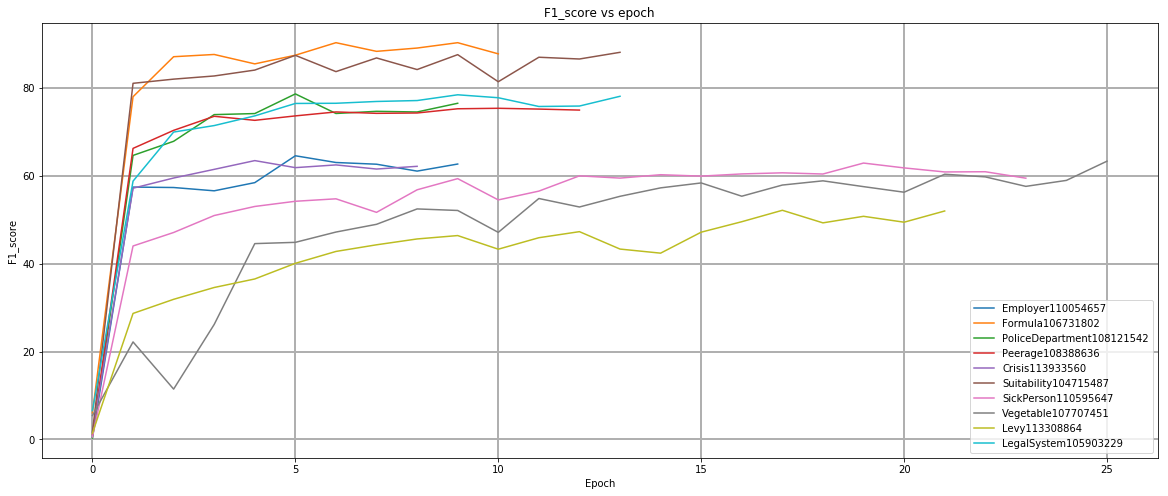

In [132]:
# check the convergence
# randomly choosing entities
n_entity = len(ls_vs_epoch1)
ls_entities = []
ls_epoch = []
for i in range(10):
    index = random.randint(1000,1200)
    ls_epoch.append(ls_vs_epoch1[index])
    ls_entities.append(df_NeuroNER1.iloc[index]['entity_type'])

# plot the accuracy against the degree# plot th 
plt.figure(figsize=(20,8))
for i,entity in enumerate(ls_entities):
    x = list(range(len(ls_epoch[i])))
    y = ls_epoch[i]
#     n_sentence = int(df_all[df_all['entity_type'] == entity]['n_sentence'])
    label = entity 
    plt.plot(x,y, label = label)
#     print(entity)
plt.title("F1_score vs epoch")
plt.xlabel("Epoch")
plt.ylabel("F1_score")
plt.grid(linestyle='-', linewidth=2)
plt.legend()
plt.show()

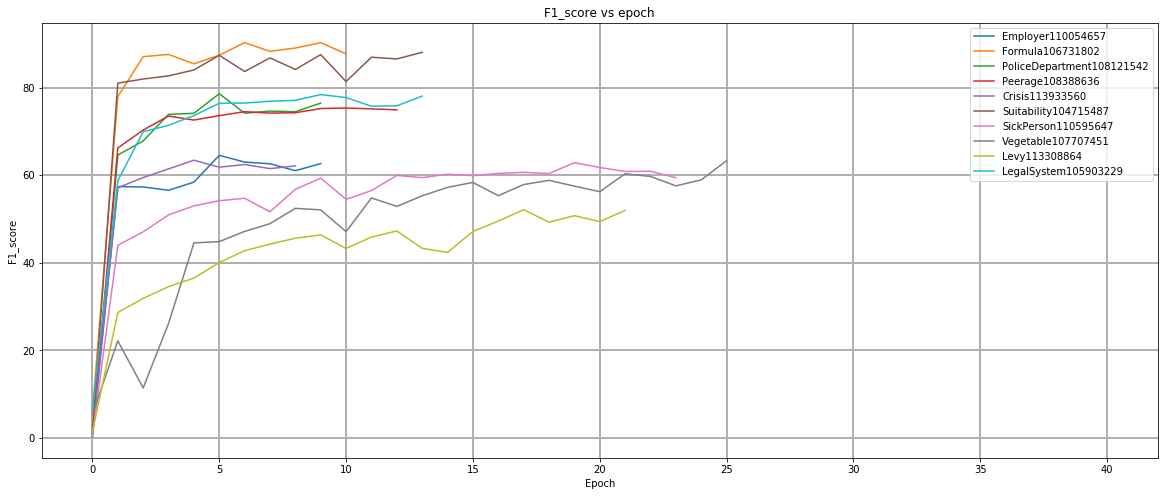

<Figure size 432x288 with 0 Axes>

In [139]:
plt.figure(figsize=(20,8))
for i,entity in enumerate(ls_entities):
    x = list(range(len(ls_epoch[i])))
    y = ls_epoch[i]
#     n_sentence = int(df_all[df_all['entity_type'] == entity]['n_sentence'])
    label = entity 
    plt.plot(x,y, label = label)
#     print(entity)
plt.plot(40.0,0)
plt.title("F1_score vs epoch")
plt.xlabel("Epoch")
plt.ylabel("F1_score")
plt.grid(linestyle='-', linewidth=2)
plt.legend()
plt.show()
plt.savefig("stop_fixed.pdf")

In [143]:
df_all.head(3)

entity_type  n_sentence  F1_Stanford  F1_Stanford_std  \
0        Belemnite101973723          84      0.91580         0.080437   
1  PlanetaryNebula109394797          88      0.81528         0.047105   
2        Threadfin102610980          93      0.61946         0.135302   

     N_avg     N_std      S_N  
0  0.93854  0.062187 -0.02274  
1  0.80550  0.037686  0.00978  
2  0.76570  0.122709 -0.14624

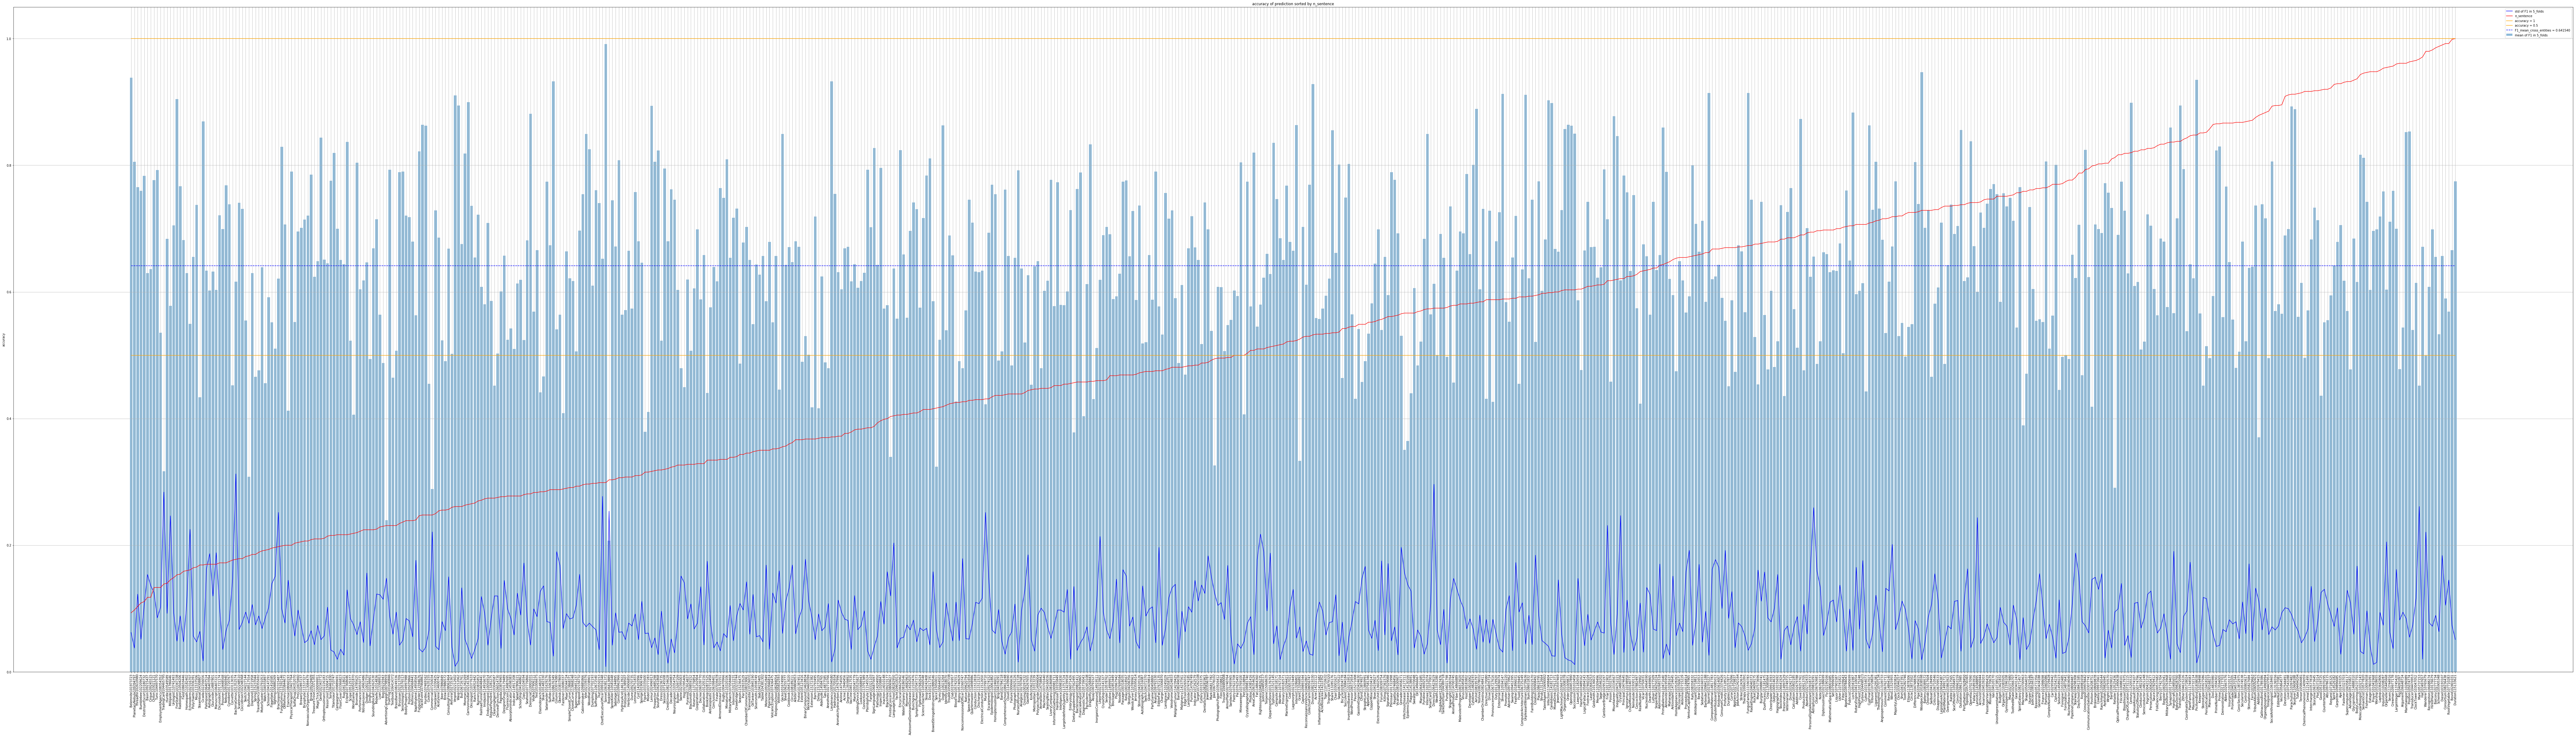

In [146]:
# sorted by n_document/# n_sentence / # sorted by F1_mean
ls_entity = df_all['entity_type'].values
ls_F1_mean = df_all['N_avg'].values
ls_F1_std = df_all['N_std'].values


ls_n_sentence = df_all['n_sentence'].values
ls_n_sentence = ls_n_sentence / max(ls_n_sentence)


ls_n_F1_mean = 0.641540 * np.ones(len(ls_F1_mean))


y_pos = np.arange(len(ls_F1_mean))

fig, ax = plt.subplots(figsize=(150,40)) 
plt.bar(y_pos, ls_F1_mean, align='center', alpha=0.5, label = 'mean of F1 in 5_folds')
plt.plot(y_pos,ls_F1_std, color = 'b', label = 'std of F1 in 5_folds')
# plt.plot(y_pos,ls_R, color = 'black', label = 'mean of R  in 5_folds')
# plt.plot(y_pos,ls_P, color = 'g', label = 'mean of P  in 5_folds')
plt.plot(y_pos,ls_n_sentence, color = 'r', label = 'n_sentence')
plt.plot(y_pos,np.ones(len(ls_F1_mean)), color = 'orange', label = 'accuracy = 1')
plt.plot(y_pos,np.ones(len(ls_F1_mean))/2, color = 'orange', label = 'accuracy = 0.5')

plt.plot(y_pos,ls_n_F1_mean, color = 'b',linestyle = '--',label = 'F1_mean_cross_entities = 0.641540')



plt.xticks(y_pos, ls_entity,rotation='vertical')
plt.ylabel('accuracy')
plt.title('accuracy of prediction sorted by n_sentence')

plt.grid()
plt.legend() 
plt.savefig('NeuroNER_711_F1_sort_by_sentence.pdf')

In [ ]:
# sorted by n_document/# n_sentence / # sorted by F1_mean
ls_entity = df_all['entity_type'].values
ls_F1_mean = df_all['N_avg'].values
ls_F1_std = df_all['N_std'].values


ls_n_sentence = df_all['n_sentence'].values
ls_n_sentence = ls_n_sentence / max(ls_n_sentence)


ls_n_F1_mean = 0.641540 * np.ones(len(ls_F1_mean))


y_pos = np.arange(len(ls_F1_mean))

fig, ax = plt.subplots(figsize=(150,40)) 
plt.bar(y_pos, ls_F1_mean, align='center', alpha=0.5, label = 'mean of F1 in 5_folds')
plt.plot(y_pos,ls_F1_std, color = 'b', label = 'std of F1 in 5_folds')
# plt.plot(y_pos,ls_R, color = 'black', label = 'mean of R  in 5_folds')
# plt.plot(y_pos,ls_P, color = 'g', label = 'mean of P  in 5_folds')
plt.plot(y_pos,ls_n_sentence, color = 'r', label = 'n_sentence')
plt.plot(y_pos,np.ones(len(ls_F1_mean)), color = 'orange', label = 'accuracy = 1')
plt.plot(y_pos,np.ones(len(ls_F1_mean))/2, color = 'orange', label = 'accuracy = 0.5')

plt.plot(y_pos,ls_n_F1_mean, color = 'b',linestyle = '--',label = 'F1_mean_cross_entities = 0.641540')



plt.xticks(y_pos, ls_entity,rotation='vertical')
plt.ylabel('accuracy')
plt.title('accuracy of prediction sorted by n_sentence')

plt.grid()
plt.legend() 
plt.savefig('711_substract_line.pdf')

In [157]:
print('entities that StanfordnER better than NeuroNER:',sum(df_all['S_N'] > 0))
print('entities that NeuroNER better than StanfordnER:',sum(df_all['S_N'] < 0))

entities that StanfordnER better than NeuroNER: 247
entities that NeuroNER better than StanfordnER: 464


In [159]:
np.mean([x for x in bars3 if x <0])

-0.07304306034482759

In [2]:
# load Stanford NER result and merge them
file_path = '../RPI_2018_statistic_all_1235_data.csv'
df_stanfordner = pd.DataFrame.from_csv(file_path).sort_values('n_sentence')

/Users/liangjianzhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
df_stanfordner.head(2)

entity_type  n_document  n_sentence  n_token  n_entity  \
1019        Belemnite101973723           1          84     1133       118   
54    PlanetaryNebula109394797           1          88     1646       101   

      F1_mean    F1_std  FN_mean  FP_mean  TP_mean   P_mean   R_mean  
1019  0.91580  0.080437      0.8      3.2     22.8  0.87976  0.96478  
54    0.81528  0.047105      4.6      2.6     15.6  0.86286  0.77390

In [7]:
# sorted by n_document/# n_sentence / # sorted by F1_mean
ls_entity = df_stanfordner['entity_type'].values
ls_F1_mean = df_stanfordner['F1_mean'].values
ls_F1_std = df_stanfordner['F1_std'].values


ls_n_sentence = df_stanfordner['n_sentence'].values
ls_n_sentence = ls_n_sentence / max(ls_n_sentence)


ls_n_F1_mean = 0.641540 * np.ones(len(ls_F1_mean))


y_pos = np.arange(len(ls_F1_mean))

fig, ax = plt.subplots(figsize=(150,40)) 
plt.bar(y_pos, ls_F1_mean, align='center', alpha=0.5, label = 'mean of F1 in 5_folds')
plt.plot(y_pos,ls_F1_std, color = 'b', label = 'std of F1 in 5_folds')
# plt.plot(y_pos,ls_R, color = 'black', label = 'mean of R  in 5_folds')
# plt.plot(y_pos,ls_P, color = 'g', label = 'mean of P  in 5_folds')
plt.plot(y_pos,ls_n_sentence, color = 'r', label = 'n_sentence')
plt.plot(y_pos,np.ones(len(ls_F1_mean)), color = 'orange', label = 'accuracy = 1')
plt.plot(y_pos,np.ones(len(ls_F1_mean))/2, color = 'orange', label = 'accuracy = 0.5')

plt.plot(y_pos,ls_n_F1_mean, color = 'b',linestyle = '--',label = 'F1_mean_cross_entities = 0.641540')



plt.xticks(y_pos, ls_entity,rotation='vertical')
plt.ylabel('accuracy')
plt.title('accuracy of prediction sorted by n_sentence')

plt.gca().yaxis.grid(True)
plt.legend() 
plt.savefig('StanfordNER1235_F1_sort_by_sentence.pdf')